# Example of Liberia PV-BESS sizing analysis

This notebook enables to post-process the results of the Energy Planning Model (EPM) to obtain the main figures. Importantly, it enables to compare multiple scenarios. In the result of the folder, there are subfolders for each scenario. The notebook will loop over all the scenarios to get the data, and then plot the figures.

**Disclaimer: You need to adapt to your own case, as the EPM results are specific to each case. These plots have been made with the code from the `liberia` branch, which differs slightly from the `main` branch. In addition, the `main` branch may have evolved since the Liberia simulations were made. Therefore, calls to the functions will need to be adapted to our own case.**

Here, we will use the results of the EPM for the sizing of PV/BESS in Liberia. The EPM .gdx files are stored in the /output/simulations_run_20250103_150855 folder. 

For the sake of this example, we will display the figures in the notebook, but there are usually not displayed in the notebook.

In [1]:
import sys
from fileinput import filename

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
sys.path.append('..')

from utils import (read_plot_specs, create_folders_imgs, extract_epm_results, process_epmresults, make_demand_plot,
                   make_generation_plot, calculate_pRR, make_fuel_energy_mix_pie_plot, make_batteries_role_plot, make_fuel_capacity_mix_pie_plot,
                   create_df_bess_usage, make_stacked_areaplot, dispatch_plot, make_fuel_dispatch_plot, make_complete_fuel_dispatch_plot,
                   make_fuel_capacity_mix_bar_plot, make_summary, make_stacked_barplot, bar_plot_new)
plt.ioff()  # turning off interactive mode

# Extracting data

## Specifications

In [2]:
REGION_NAME = 'Liberia'  # name of the region


RESULTS_FOLDER = '../output/simulations_run_20250103_150855'  

# SCENARIO = 'baseline'
dict_specs = read_plot_specs()

# How to group technologies for some plots
fuel_grouping = {
    'Battery Storage 4h': 'Battery Discharge',
    'Battery Storage 8h': 'Battery Discharge',
    'Battery Storage 2h': 'Battery Discharge',
    'Battery Storage 3h': 'Battery Discharge',
    'Oil diesel': 'Oil',
    'Hydro MC': 'MtCoffee',
    'Hydro RoR': 'SP2',
    'Hydro Storage': 'Hydro'
}

# Rename scenarios for the plots
scenario_names = {
    'baseline': 'Baseline',
    'HydroStorage_NoSP2': 'No SP2',
    'HydroStorage_SolarPessimistic': 'HighHydro+Flex',
    'HydroStorage_DemandHigh': 'High Demand',
    'HydroStorage_HydroHigh': 'High Hydro',
    'HydroStorage_LowHydro': 'Low Hydro',
    'HydroStorage_LowImport_LowThermal': 'Low Import Low Thermal',
    'HydroStorage_LowImportReserve': 'Low Import Reserve',
    'HydroStorage_ForcingBatteries': 'Forcing Batteries',
    'HydroStorage_HighImport': 'High Import',
    'HydroStorage_LateSP2': 'Late SP2',
    'HydroStorage_OldRef': 'Old Reference',
    'baselineRoR': 'Limited Flexibility'
}

def rename_scenarios(x):
    return scenario_names.get(x,x)

In [3]:
### Processing results
# selected_scenario = SCENARIO

epmresults, scenarios = extract_epm_results(RESULTS_FOLDER)  # SCENARIO

epm_dict = process_epmresults(epmresults, dict_specs, input=Path('../input'))

create_folders_imgs(RESULTS_FOLDER)

 Scenarios in the folder: ['HydroStorage_LateSP2', 'HydroStorage_HighImport', 'baseline', 'HydroStorage_LowHydro', 'baselineRoR', 'HydroStorage_LowImport_LowThermal']


/Users/celia/Documents/WorldBank/Energy_planning/EPM/epm/utils.py:239: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  epm_dict[key].groupby(


# Figures

## Scenario-specific figures

### Dispatch plots

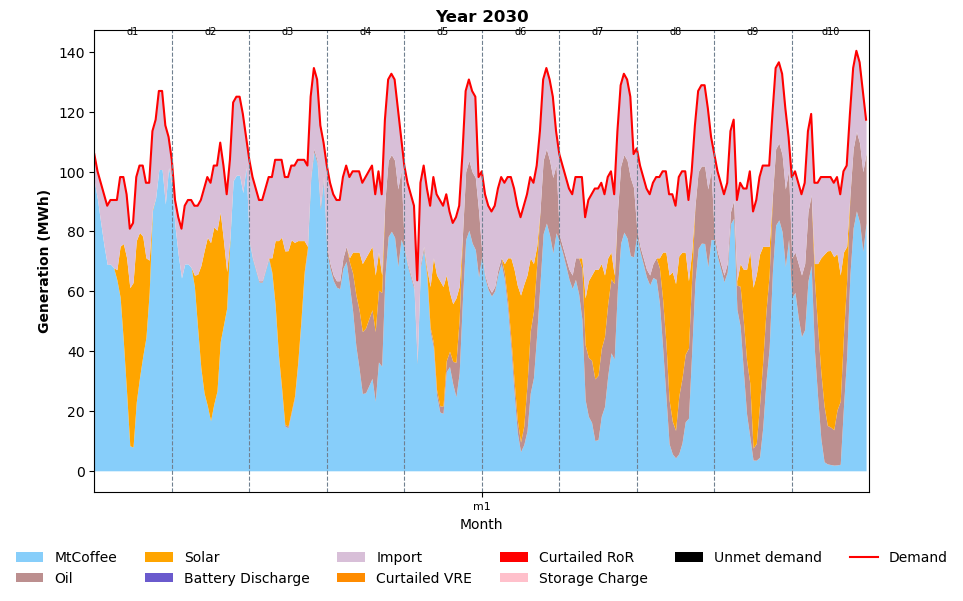

In [4]:
### Dispatch plots

scenario = 'baseline'

subset_dispatch = epm_dict['pDispatch'].loc[
epm_dict['pDispatch'].attribute.isin(['Unmet demand', 'Exports', 'Storage Charge'])]

# Selecting what we want to plot as area in the plot
dfs_to_plot_area = {
    'pFuelDispatch': epm_dict['pFuelDispatch'],
    'pCurtailedVRET': epm_dict['pCurtailedVRET'],
    'pCurtailedStoHY': epm_dict['pCurtailedStoHY'],
    'pDispatch': subset_dispatch
}

subset_demand = epm_dict['pDispatch'].loc[epm_dict['pDispatch'].attribute.isin(['Demand'])]

# Selecting what we want to plot as a line in the plot
dfs_to_plot_line = {
    'pDispatch': subset_demand
}

select_time = {
    'season': ['m1'],
    'day': ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10']
}


folder = None  # only for display in the notebook
make_complete_fuel_dispatch_plot(dfs_to_plot_area, dfs_to_plot_line, folder=folder, dict_colors=dict_specs['colors'], 
                         zone='Liberia', year=2030, scenario=scenario, fuel_grouping=fuel_grouping,
                         select_time=select_time, reorder_dispatch=['MtCoffee', 'SP2', 'Oil', 'Solar'], season=False)
        


## Battery operation plot

/Users/celia/Documents/WorldBank/Energy_planning/EPM/epm/utils.py:628: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


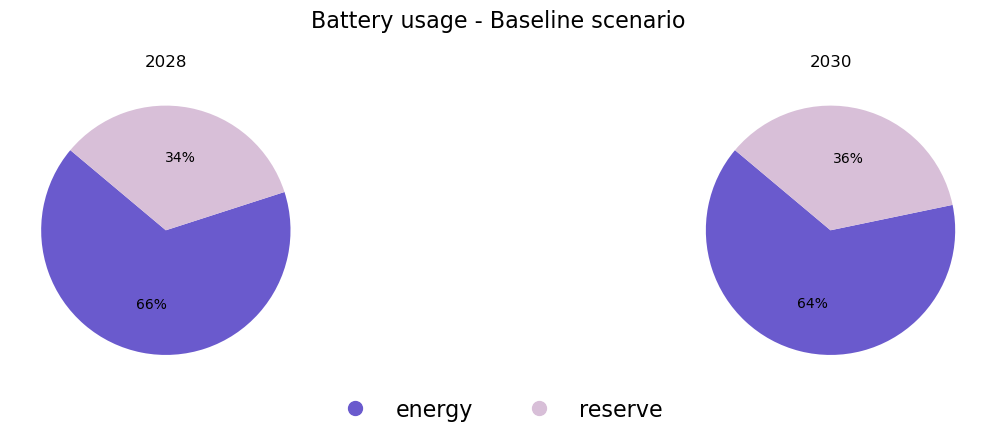

In [5]:
make_batteries_role_plot(epm_dict['pFuelDispatch'], epm_dict['pReserveByPlant'], 
                         fuel_list=['Battery Storage 2h', 'Battery Storage 3h','Battery Storage 4h', 'Battery Storage 8h'], 
                         years=[2028, 2030], folder=None, dict_colors=dict_specs['colors'],
                         selected_scenario=scenario, percent_cap=2, scenario_names=scenario_names)

## Aggregate plots

### Capacity mix (by fuel) comparison  

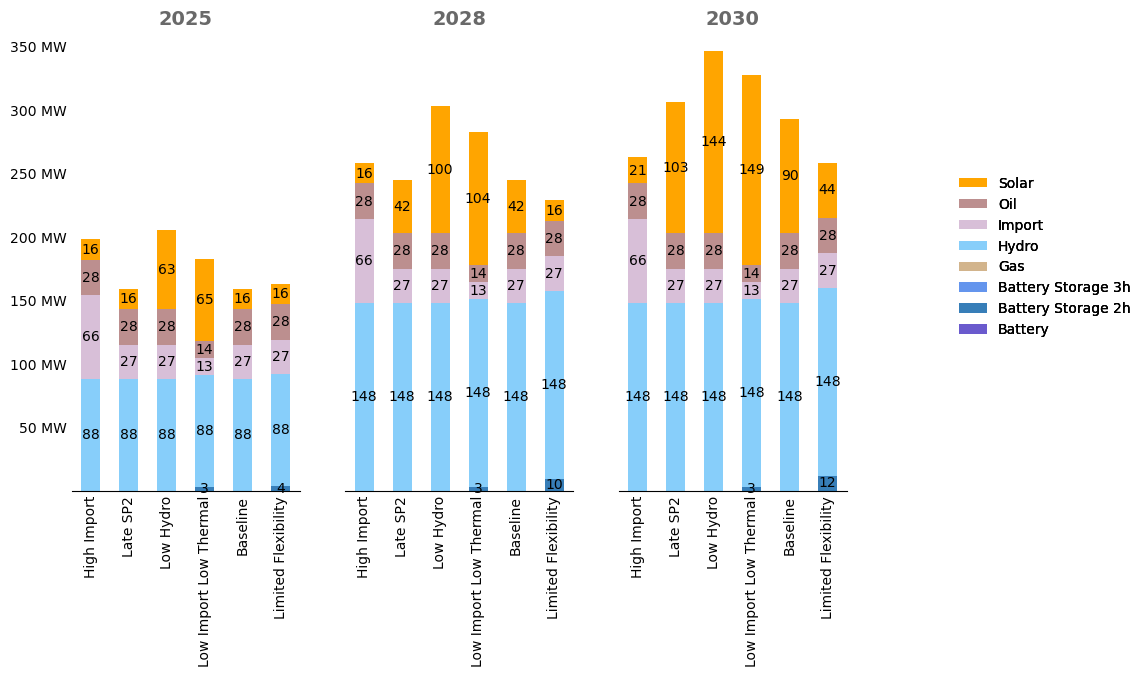

In [6]:
fuel_grouping = {
    'Battery Storage 4h': 'Battery',
    'Battery Storage 8h': 'Battery',
    'Oil diesel': 'Oil',
    'Hydro MC': 'Hydro',
    'Hydro RoR': 'Hydro',
    'Hydro Storage': 'Hydro'
}

filename = None
stacked_grouping = {
    'fuel': fuel_grouping
}
make_stacked_barplot(epm_dict['pCapacityFuel'], filename, dict_specs['colors'], zone='Liberia',
                          column_xaxis='year', column_stacked='fuel', column_multiple_bars='scenario',
                          select_xaxis=[2025, 2028, 2030], stacked_grouping=stacked_grouping, rename_scenarios=rename_scenarios,
                           # order_scenarios=['Baseline', 'High Hydro', 'High Demand', 'LowImport_LowThermal'],
                           format_y=lambda y, _: '{:.0f} MW'.format(y)
                           )

### Capacity mix by plant

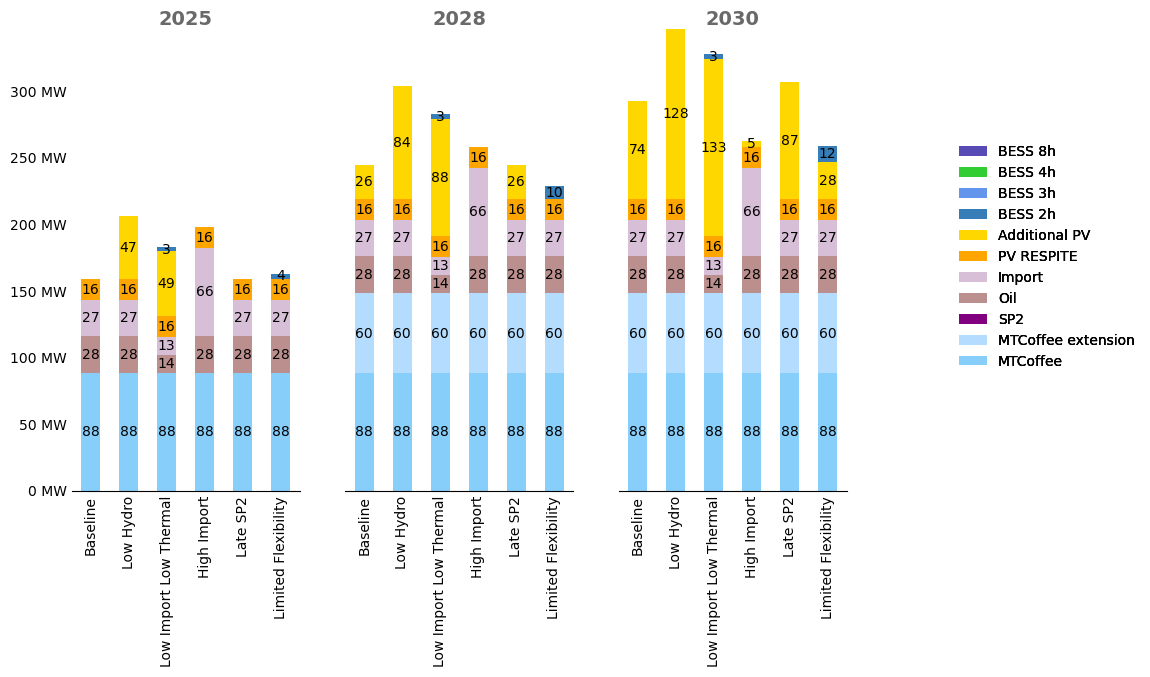

In [7]:
# We rename the generators, as we work by generation instead of by plant here - plot when greater level of detail is needed

generator_renaming = {
    'PV_CAND_LIB': 'Additional PV',
    'PV_2026': 'PV 2026',
    'PV_2028': 'PV 2028',
    'PV_2030': 'PV 2030',
    'PV_RESPITE': 'PV RESPITE',
    'Bushrod': 'Oil',
    'CLSG_CIV': 'Import',
    'SP2_150': 'SP2',
    'MTCoffee_extension': 'MTCoffee extension',
}

dict_colors_plants = {
    'Import': 'thistle',
    'PV RESPITE': 'orange',
    'Additional PV': 'gold',
    'PV 2026': 'gold',
    'PV 2028': 'gold',
    'PV 2030': 'gold',
    'BESS_4h': 'limegreen',
    'BESS_2h': '#377EB8',
    'BESS_2h_committed': '#377EB8',
    'BESS_3h': 'cornflowerblue',
    'BESS_8h': '#584BB5',
    'MTCoffee':'lightskyblue',
    'MTCoffee extension':'#b4dcff',
    'SP2':'purple',
    'Oil': 'rosybrown',
}

filename=None
stacked_grouping = {
    'generator': generator_renaming
}
make_stacked_barplot(epm_dict['pCapacityPlan'], filename, dict_colors=dict_colors_plants, zone='Liberia',
                          column_xaxis='year', column_stacked='generator', column_multiple_bars='scenario',
                          select_xaxis=[2025, 2028, 2030], stacked_grouping=stacked_grouping, rename_scenarios=rename_scenarios,
                          order_scenarios=['Baseline', 'Low Hydro', 'Low Import Low Thermal', 'High Import', 'Late SP2', 'Limited Flexibility'],
                          format_y=lambda y, _: '{:.0f} MW'.format(y),
                          order_stacked=['MTCoffee', 'MTCoffee extension', 'SP2', 'Oil', 'Import', 'PV RESPITE', 'Additional PV'], cap=2
                           )

### Energy reserve comparison 

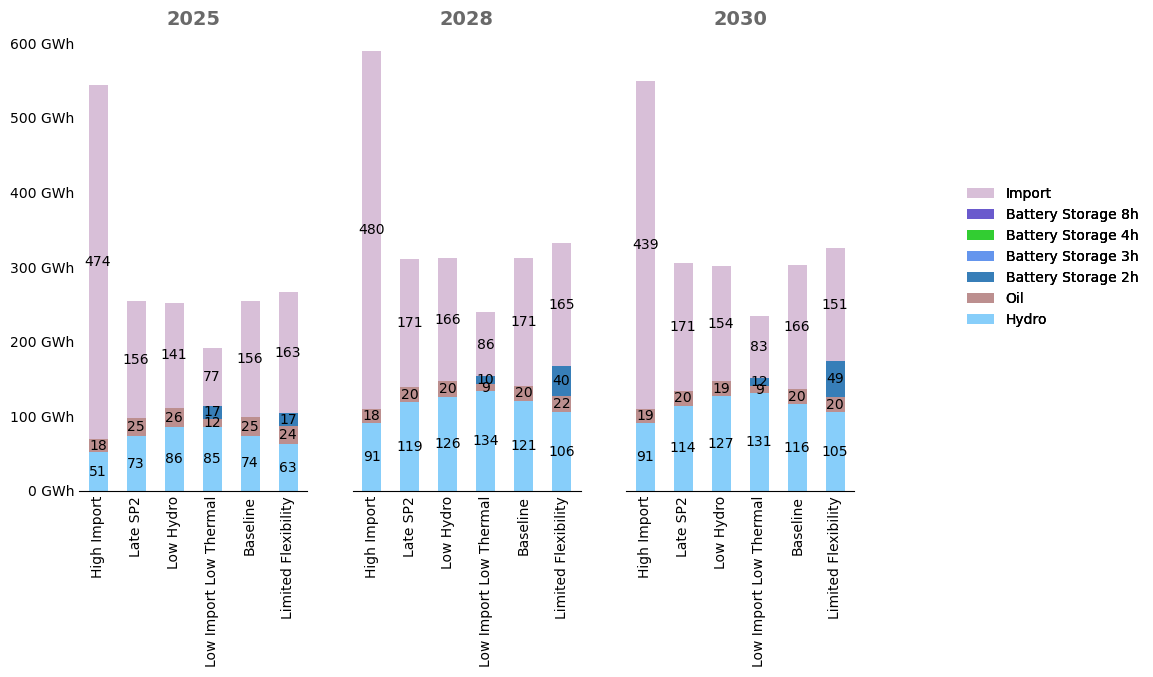

In [8]:
# We change the fuel grouping to obtain detailed battery data
fuel_grouping = {
    'Oil diesel': 'Oil',
    'Hydro MC': 'Hydro',
    'Hydro RoR': 'Hydro',
    'Hydro Storage': 'Hydro'
}

filename = None
stacked_grouping = {
    'fuel': fuel_grouping
}
make_stacked_barplot(epm_dict['pReserveByPlant'], filename, dict_colors=dict_specs['colors'], zone='Liberia',
                          column_xaxis='year', column_stacked='fuel', column_multiple_bars='scenario',
                          select_xaxis=[2025, 2028, 2030], stacked_grouping=stacked_grouping, rename_scenarios=rename_scenarios,
                          # order_scenarios=['Baseline', 'Limited Flexibility'],
                          format_y=lambda y, _: '{:.0f} GWh'.format(y),
                          order_stacked=['Hydro', 'Oil'], cap=2
                           )